In [1]:
library(ggplot2)
library(qvalue)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
Giordanos_selection = "/hps/nobackup/stegle/users/galvari/data/iPSCs/singleCell/metadata/ensembl_gene/Ensembl_75_Gene_CV_quant5.txt"
G_file = read.csv(Giordanos_selection, sep = "\t")
nrow(G_file)
head(G_file,2)

[1] 21592

,gene,mean,std,CV,quartile_cv
2,ENSG00000227232,3.1805905,3.6232403,1.139172,2
3,ENSG00000243485,0.2003178,0.8649483,4.317881,3


In [3]:
#### Bulk files

In [4]:
## matched samples only (matched bulk)
bulk_matched_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/Bulk/BulkDay0Healthy_PCA20_88_206/"
res = read.csv(paste0(bulk_matched_folder,"qtl_results_all.txt"), sep = "\t")
nrow(res)

[1] 16691457

In [5]:
# all available samples (bulk all)
bulk_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/Bulk/BulkTotal_PCA20/"
res_all = read.csv(paste0(bulk_folder,"qtl_results_all.txt"), sep = "\t")
nrow(res_all)

In [6]:
##### Mean

In [7]:
mean_folder = "/hps/nobackup/hipsci/scratch/ComparingQtlMapping/SingleCell/PseudoBulk/mean/"

In [8]:
#### All chromosomes

In [9]:
my_folder = paste0(mean_folder,"Run_Output_PCA5_88_log_TPM_scater_libsize_206/") # scran, 5PCs
df0 = read.csv(paste0(my_folder,"top_qtl_results_all.txt"), sep = "\t")
chr2_genes = unique(df0$feature_id)
length(chr2_genes)

[1] 50425

In [10]:
number_of_covs = c(5,10,15,20,25)

In [11]:
## PCs
PC_suffix = paste0("Run_Output_PCA",number_of_covs,"_88_log_TPM_scater_libsize_206/")
## PEER
PEER_suffix = paste0("Run_Output_PEER",number_of_covs,"_88_log_TPM_scater_libsize_206/")
## MOFA sparse
MOFA_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206/")
# MOFA_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206_correct/")
## MOFA non-sparse
MOFA_ns_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206_nonsparse/")
## linear scVI (LDVAE)
LDVAE_suffix = paste0("Run_Output_LDVAE",number_of_covs,"_88_log_TPM_scater_libsize_206/")

In [12]:
# number_of_covs = c(5,10,15,25)
# ## MOFA sparse
# MOFA_suffix = paste0("Run_Output_MOFA",number_of_covs,"_88_log_TPM_scater_libsize_206/")

In [13]:
suffixes = c(PC_suffix, PEER_suffix, MOFA_suffix, MOFA_ns_suffix, LDVAE_suffix)
length(suffixes)

[1] 25

In [14]:
filenames = paste0(mean_folder, suffixes, "top_qtl_results_all.txt")

In [15]:
## get FDR threshold from bulk

In [16]:
## m-bulk
leads = read.csv(paste0(bulk_matched_folder,"top_qtl_results_all.txt"), sep = "\t")
nrow(leads)

[1] 43103

In [17]:
df0 = leads
df0 <- df0[-which(duplicated(df0$feature_id)),]
length(unique(df0$feature_id))
df0 = df0[df0$feature_id %in% chr2_genes,]
df1 = df0[df0$feature_id %in% G_file$gene,]
df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues

[1] 42791

In [18]:
max_qval = max(df1[df1$q_value < 0.1,'q_value'])
max_qval
emp_pv_star_matched = max(df1[df1$q_value==max_qval,"empirical_feature_p_value"])
emp_pv_star_matched
T1 = emp_pv_star_matched

[1] 0.09994498

[1] 0.04418403

In [19]:
## a-bulk
leads_all = read.csv(paste0(bulk_folder,"top_qtl_results_all.txt"), sep = "\t")
nrow(leads_all)

[1] 49916

In [20]:
df0 = leads_all
df0 <- df0[-which(duplicated(df0$feature_id)),]
df0 = df0[df0$feature_id %in% chr2_genes,]
df1 = df0[df0$feature_id %in% G_file$gene,]
df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues

In [21]:
max_qval = max(df1[df1$q_value < 0.1,'q_value'])
max_qval
emp_pv_star_all = max(df1[df1$q_value==max_qval, "empirical_feature_p_value"])
emp_pv_star_all
T2 = emp_pv_star_all

[1] 0.09989272

[1] 0.3221901

In [22]:
df = data.frame()

In [23]:
for (file in filenames){
    ## open file
    df0 = read.csv(file, sep = "\t")
    ## chr 2 genes only
    df0 = df0[df0$feature_id %in% chr2_genes,]
    ## select variable genes only
#     df1 = df0
    df1 = df0[df0$feature_id %in% G_file$gene,]
    ## multiple testing correction
    df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues
    ## select significant snp-gene pairs only (FDR<5%)
    df3 = df1[df1$q_value < 0.05,]
    ## bulk replication
    # m-bulk
    df4 = inner_join(df3, res, by = c("snp_id","feature_id"), suffix = c(".sc",".bulk"))
    n_eqtl_m = length(unique(df4$feature_id))
    n_replicated_m = length(unique(df4[(df4$empirical_feature_p_value.bulk < T1 & (df4$beta.sc*df4$beta.bulk)>0),]$feature_id))
    # a-bulk
    df5 = inner_join(df3, res_all, by = c("snp_id","feature_id"), suffix = c(".sc",".bulk"))
    n_eqtl_a = length(unique(df5$feature_id))
    n_replicated_a = length(unique(df5[(df5$empirical_feature_p_value.bulk < T2 & (df5$beta.sc*df5$beta.bulk)>0),]$feature_id))
    df = rbind(df, data.frame(n_eqtl_m = n_eqtl_m, n_replicated_m = n_replicated_m,
                             n_eqtl_a = n_eqtl_a, n_replicated_a = n_replicated_a))    
}

Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with differe

“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coerci

In [24]:
df$method = c("PCA","PCA","PCA","PCA","PCA",
             "PEER","PEER","PEER","PEER","PEER",
             "MOFA","MOFA","MOFA","MOFA","MOFA",
             "MOFA-ns","MOFA-ns","MOFA-ns","MOFA-ns","MOFA-ns",
             "LDVAE","LDVAE","LDVAE","LDVAE","LDVAE")

In [25]:
df$n_covs = c(number_of_covs,number_of_covs,number_of_covs,number_of_covs,number_of_covs)

In [28]:
## add results with no covariates
my_folder = paste0(mean_folder,"Run_Output_NoFactor_88_log_TPM_scater_libsize_206/") 
file = paste0(my_folder,"top_qtl_results_all.txt")

In [29]:
df0 = read.csv(file, sep = "\t")
df0 = df0[df0$feature_id %in% chr2_genes,]
#     df1 = df0
df1 = df0[df0$feature_id %in% G_file$gene,]
df1$q_value = qvalue(df1$empirical_feature_p_value)$qvalues
df3 = df1[df1$q_value < 0.05,]
nrow(df3)
df4 = inner_join(df3, res, by = c("snp_id","feature_id"), suffix = c(".sc",".bulk"))
nrow(df4)

[1] 1123

Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”

[1] 1119

In [30]:
n_eqtl_m = length(unique(df4$feature_id))
n_replicated_m = length(unique(df4[(df4$empirical_feature_p_value.bulk < T1 & (df4$beta.sc*df4$beta.bulk)>0),]$feature_id))
df5 = inner_join(df3, res_all, by = c("snp_id","feature_id"), suffix = c(".sc",".bulk"))
n_eqtl_a = length(unique(df5$feature_id))
n_replicated_a = length(unique(df5[(df5$empirical_feature_p_value.bulk < T2 & (df5$beta.sc*df5$beta.bulk)>0),]$feature_id))
df_0 = data.frame(n_eqtl_m = n_eqtl_m, n_replicated_m = n_replicated_m, 
                n_eqtl_a = n_eqtl_a, n_replicated_a = n_replicated_a, 
                n_covs = 0, 
                method = c("PCA","PEER","MOFA","MOFA-ns","LDVAE"))
df_0

Warning message:
“Column `snp_id` joining factors with different levels, coercing to character vector”Warning message:
“Column `feature_id` joining factors with different levels, coercing to character vector”

n_eqtl_m,n_replicated_m,n_eqtl_a,n_replicated_a,n_covs,method
1108,568,1115,793,0,PCA
1108,568,1115,793,0,PEER
1108,568,1115,793,0,MOFA
1108,568,1115,793,0,MOFA-ns
1108,568,1115,793,0,LDVAE


In [31]:
df_to_plot = rbind(df, df_0)
df_to_plot$pct_repl_m = (df_to_plot$n_replicated_m/df_to_plot$n_eqtl_m)*100
df_to_plot$pct_repl_a = (df_to_plot$n_replicated_a/df_to_plot$n_eqtl_a)*100

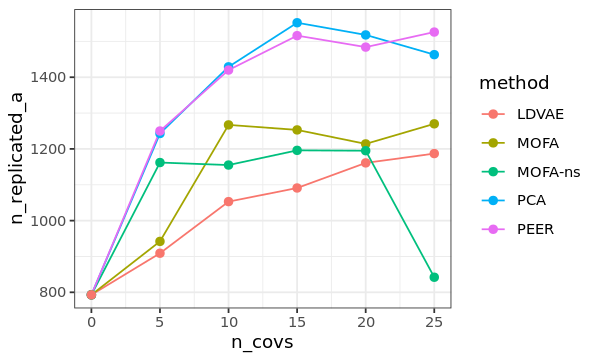

In [32]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(df_to_plot, aes(x = n_covs, y = n_replicated_a, colour = method)) + geom_line() + geom_point(size=2) + theme_bw()

In [33]:
### older (MOFA non sparse)

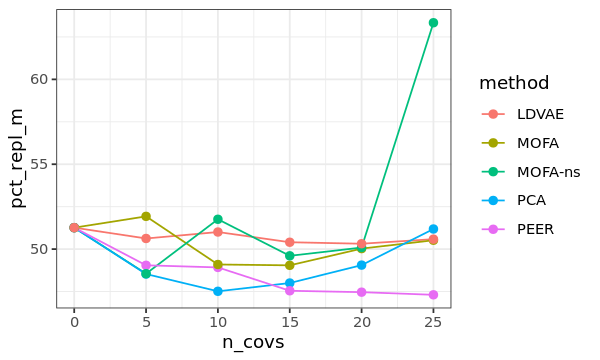

In [34]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(df_to_plot, aes(x = n_covs, y = pct_repl_m, colour = method)) + geom_line() + geom_point(size=2) + theme_bw()

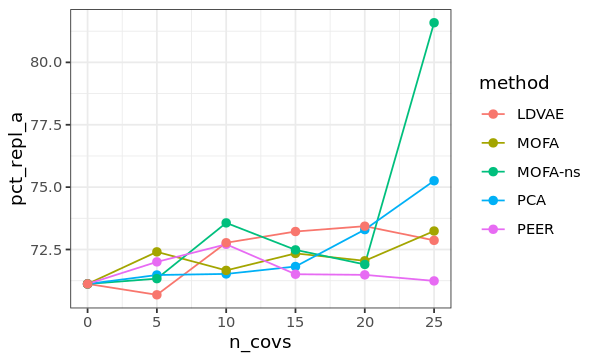

In [35]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(df_to_plot, aes(x = n_covs, y = pct_repl_a, colour = method)) + geom_line() + geom_point(size=2) + theme_bw()

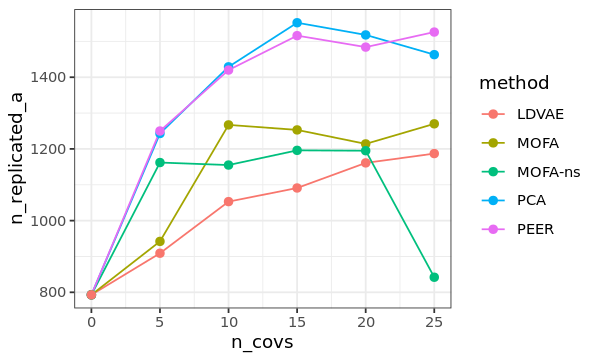

In [36]:
options(repr.plot.width = 5, repr.plot.height = 3)
ggplot(df_to_plot, aes(x = n_covs, y = n_replicated_a, colour = method)) + geom_line() + geom_point(size=2) + theme_bw()

In [37]:
write.csv(df_to_plot, "/hps/nobackup/stegle/users/acuomo/all_scripts/sc_eqtl/covariate_table_repl_FDR10_all_chromosomes.csv")